In [11]:
import numpy as np
import xarray as xr
import pystac
import pystac_client
import rasterio
import requests
from typing import List, Optional, cast
from pystac import Collection, MediaType
from pystac_client import Client, CollectionClient
from datetime import datetime
#import geopandas as gpd
import matplotlib as plt
import matplotlib.pyplot as plt

## open catalog

In [12]:
stacURL = 'https://stac.core.eopf.eodc.eu/'
eopf_catalog = Client.open(stacURL) 

## open collection

In [13]:
s1grdID = 'sentinel-1-l1-grd'
s1grd = eopf_catalog.get_collection(s1grdID)

## search on catalog

In [18]:
def list_found_elements(search_result):
    ids = []
    coll = []
    funk()
    for item in search_result.items(): 
        ids.append(item.id)
        coll.append(item.collection_id)
    return ids , coll

In [17]:
search_catalog = eopf_catalog.search(
    collections = s1grd, datetime = "2025-07-06T18:34:00Z/2025-07-06T18:37:59Z", bbox=(-9.283880, 38.634131, -8.964918, 38.810976)) 

print("This is how our search literally looks: ", search_catalog)

items = list_found_elements(search_catalog)
print("Found", len(items[0]), "products on this search.")
print(items[0])

This is how our search literally looks:  <pystac_client.item_search.ItemSearch object at 0x122d060d0>


NameError: name 'funk' is not defined

## .zarr product

In [93]:
product_id = items[0][0] 
item = s1grd.get_item(product_id) 
zarr_assets = item.get_assets(media_type=MediaType.ZARR)
assets_loc = [zarr_assets]
the_item = assets_loc[0]

zarr_product_URL = the_item['product'].href

## data_tree and data_set

In [7]:
data_tree = xr.open_datatree(zarr_product_URL, engine = "zarr", chunks={})

for i in sorted(data_tree.groups):
    print(i)

/
/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH
/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH/conditions
/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH/conditions/antenna_pattern
/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH/conditions/attitude
/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH/conditions/azimuth_fm_rate
/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH/conditions/coordinate_conversion
/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH/conditions/doppler_centroid
/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH/conditions/gcp
/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH/conditions/orbit
/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH/conditions/reference_replica
/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH/conditions/replica
/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH/conditions/terrain_height
/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH/measurements
/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH/quali

In [94]:
data_set = xr.open_dataset(zarr_product_URL, engine = "zarr", chunks={},
    group = "/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH/conditions/orbit")

print(data_set)

<xarray.Dataset> Size: 952B
Dimensions:       (azimuth_time: 17, axis: 3)
Coordinates:
  * azimuth_time  (azimuth_time) datetime64[ns] 136B 2025-07-06T18:34:32.5215...
Dimensions without coordinates: axis
Data variables:
    position      (azimuth_time, axis) float64 408B dask.array<chunksize=(17, 3), meta=np.ndarray>
    velocity      (azimuth_time, axis) float64 408B dask.array<chunksize=(17, 3), meta=np.ndarray>


In [73]:
grd = data_tree[data_tree.groups[1]]["measurements/grd"].to_dataset()
print(grd)

<xarray.Dataset> Size: 868MB
Dimensions:       (azimuth_time: 16695, ground_range: 26006)
Coordinates:
  * azimuth_time  (azimuth_time) uint16 33kB 19608 9752 65432 ... 61727 51872
Dimensions without coordinates: ground_range
Data variables:
    grd           (azimuth_time, ground_range) uint16 868MB dask.array<chunksize=(5161, 26006), meta=np.ndarray>


## visualization

In [48]:
grd_decimated = grd.isel(azimuth_time=slice(None, None, 10), ground_range=slice(None, None, 10))
#grd_decimated.plot.imshow(vmin=0, vmax=200)
#plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

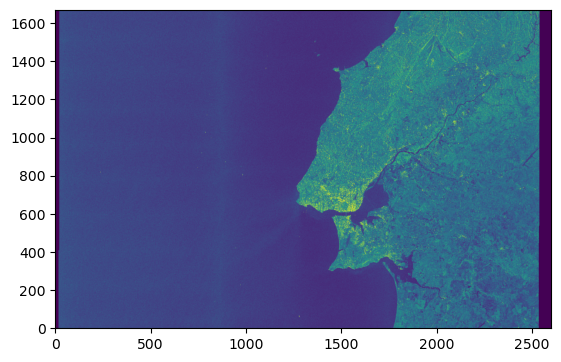

In [17]:
plt.imshow(grd_decimated, vmin=0, vmax=200)
plt.xlim(0, grd_decimated.shape[1])  
plt.ylim(0, grd_decimated.shape[0])
plt.show

## terrain correction

In [95]:
grd_decimated.to_dataset()

AttributeError: 'Dataset' object has no attribute 'to_dataset'

In [15]:
gcp = xr.open_dataset(zarr_product_URL, group="/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH/conditions/gcp", engine="zarr")
print(gcp)

<xarray.Dataset> Size: 13kB
Dimensions:           (azimuth_time: 210)
Coordinates:
  * azimuth_time      (azimuth_time) datetime64[ns] 2kB 2025-07-06T18:35:38.8...
    line              (azimuth_time) uint32 840B ...
Data variables:
    elevation_angle   (azimuth_time) float64 2kB ...
    height            (azimuth_time) float64 2kB ...
    incidence_angle   (azimuth_time) float64 2kB ...
    latitude          (azimuth_time) float64 2kB ...
    longitude         (azimuth_time) float64 2kB ...
    pixel             (azimuth_time) uint32 840B ...
    slant_range_time  (azimuth_time) float64 2kB ...


In [75]:
from sarsen import apps, scene
from sarsen import Sentinel1SarProduct

In [56]:
dem = "/Users/devseed/Documents/repos/eopf-101/notebook_S1/output_SRTMGL1.tif"

In [57]:
slant_range_time = xr.open_dataset(
    zarr_product_URL,
    engine="zarr",
    group="/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH/conditions/gcp",
    chunks={"slant_range_time": (5161, 26006)},
)
print(slant_range_time)

<xarray.Dataset> Size: 13kB
Dimensions:           (azimuth_time: 210)
Coordinates:
  * azimuth_time      (azimuth_time) datetime64[ns] 2kB 2025-07-06T18:35:38.8...
    line              (azimuth_time) uint32 840B dask.array<chunksize=(210,), meta=np.ndarray>
Data variables:
    elevation_angle   (azimuth_time) float64 2kB dask.array<chunksize=(210,), meta=np.ndarray>
    height            (azimuth_time) float64 2kB dask.array<chunksize=(210,), meta=np.ndarray>
    incidence_angle   (azimuth_time) float64 2kB dask.array<chunksize=(210,), meta=np.ndarray>
    latitude          (azimuth_time) float64 2kB dask.array<chunksize=(210,), meta=np.ndarray>
    longitude         (azimuth_time) float64 2kB dask.array<chunksize=(210,), meta=np.ndarray>
    pixel             (azimuth_time) uint32 840B dask.array<chunksize=(210,), meta=np.ndarray>
    slant_range_time  (azimuth_time) float64 2kB dask.array<chunksize=(210,), meta=np.ndarray>


In [90]:
%%time

gtc_path = "/Users/devseed/Documents/repos/eopf-101/notebook_S1.10m.GTC.tif"

product = sarsen.Sentinel1SarProduct(
    zarr_product_URL,
    "/S01SIWGRD_20250706T183538_0025_A343_4A58_077303_VH/measurements"
    #override_product_files="{dirname}/{prefix}{swath}-{polarization}{ext}",
    #chunks={"slant_range_time": 2048}
)

geocoded = sarsen.terrain_correction(
    product=product,  
    dem_urlpath="/Users/devseed/Documents/repos/eopf-101/notebook_S1/output_SRTMGL1.tif",
    output_urlpath=gtc_path,
    interp_method="nearest",
    chunks=2048,  
)

!gdaladdo -r average {gtc_path}

gtc_path

FileNotFoundError: https://objects.eodc.eu:443/e05ab01a9d56408d82ac32d69a5aae2a:202507-s01siwgrh/06/products/cpm_v256/S1A_IW_GRDH_1SDV_20250706T183538_20250706T183603_059967_077303_4A58.zarr